##### Микрокредитная организация. 
Сейчас порог отсечения для первичных клиентов (1 займ) по скорингу 200, при этом уровень просрочки 30+ составляет 24%. Какой порог отсечения необходимо поставить чтобы добиться уровня просрочки 30+ равным 15%.
Поясните целесообразность этотого шага.

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms

In [2]:
path = "C:/Users/Natalia/Karpov_courses/Тест для кандидата.xlsx"

Считываем данные из таблицы Exel, имя листа `Займы`

In [3]:
credit = pd.read_excel(path, sheet_name = 'Займы', parse_dates = [3])

In [4]:
credit.head()

,ID займа,id верификатора,"Статус займа (4 - закрыт, 3 не выплачен)",Дата выдачи займа,Дата закрытия,Какой по счету займ у клиента,Количество продлений срока погашения по этому займу,Возраст,"Пол (0 - м, 1-ж)",Количество детей,Скоринговый балл Скиба,Регион проживания,Регион паспорт,Дата погашения,Итоговое дней просрочки,Наличие просрочки ЖКХ,Наличие просрочки по кредитным картам,Наличие неоплаченных штрафов ГИБДД,Наличие производства в ФССП
0,1,3,3,2019-09-24 14:37:56,NaT,3,1,32.424658,0,1,183,Самарская обл.,Самарская обл.,2019-11-19,115,1.0,NaN,1.0,NaN
1,2,20,4,2019-09-24 15:08:01,2019-10-06 16:54:28,4,0,39.734247,1,2,222,Московская обл.,Московская обл.,2019-10-06,0,NaN,NaN,NaN,1.0
2,3,3,4,2019-09-24 15:16:11,2019-11-13 19:16:09,10,0,43.509589,1,1,422,Курская обл.,Курская обл.,2019-10-23,21,NaN,1.0,NaN,NaN
3,4,97,4,2019-09-24 15:25:08,2019-10-02 15:02:18,1,0,30.695890,1,1,142,Мурманская обл.,Мурманская обл.,2019-10-02,0,NaN,1.0,NaN,1.0
4,5,97,4,2019-09-24 15:35:12,2019-10-29 10:44:37,1,0,37.002740,0,2,441,Краснодарский край,Краснодарский край,2019-10-24,5,NaN,1.0,1.0,NaN


In [5]:
credit.columns

Index(['ID займа', 'id верификатора',
       'Статус займа (4 - закрыт, 3 не выплачен)', 'Дата выдачи займа',
       'Дата закрытия', 'Какой по счету займ у клиента',
       'Количество продлений срока погашения по этому займу', 'Возраст',
       'Пол (0 - м, 1-ж)', 'Количество детей', 'Скоринговый балл Скиба',
       'Регион проживания', 'Регион паспорт', 'Дата погашения',
       'Итоговое дней просрочки', 'Наличие просрочки ЖКХ',
       'Наличие просрочки по кредитным картам',
       'Наличие неоплаченных штрафов ГИБДД', 'Наличие производства в ФССП'],
      dtype='object')

Переименуем колонки для удобства обращения к данным:

In [6]:
credit.rename(columns = {'ID займа':'id_loan', 'id верификатора':'id_verif',
       'Статус займа (4 - закрыт, 3 не выплачен)':'status', 'Дата выдачи займа':'time_open',
       'Дата закрытия':'time_close', 'Какой по счету займ у клиента':'loan_number',
       'Количество продлений срока погашения по этому займу':'prolongation_number', 'Возраст':'age',
       'Пол (0 - м, 1-ж)':'sex', 'Количество детей':'kid_number', 'Скоринговый балл Скиба':'skib_score',
       'Регион проживания':'reg_resident', 'Регион паспорт':'reg_pass', 'Дата погашения':'date_pay',
       'Итоговое дней просрочки':'day_delay', 'Наличие просрочки ЖКХ':'delay_rent_pay',
       'Наличие просрочки по кредитным картам':'dalay_credit_card',
       'Наличие неоплаченных штрафов ГИБДД':'gibdd_penalty', 'Наличие производства в ФССП':'fssp'}, inplace = True)

Для данных в столбцах: `delay_rent_pay` (Наличие просрочки ЖКХ),`dalay_credit_card` (Наличие просрочки по кредитным картам), `gibdd_penalty`(Наличие неоплаченных штрафов ГИБДД), `fssp`(Наличие производства в ФССП) заменим пропуски `0`

In [7]:
credit.loc[:,'delay_rent_pay':'fssp'] = credit.loc[:,'delay_rent_pay':'fssp'].fillna(0)

Посммотрим на общее описание данных:

In [8]:
credit.describe()

,id_loan,id_verif,status,loan_number,prolongation_number,age,sex,kid_number,skib_score,day_delay,delay_rent_pay,dalay_credit_card,gibdd_penalty,fssp
count,11787.000000,11787.000000,11787.000000,11787.000000,11787.000000,11787.000000,11787.000000,11787.000000,11787.000000,11787.000000,11787.000000,11787.00000,11787.000000,11787.000000
mean,6451.827692,73.712225,3.762196,3.517774,0.422584,35.470678,0.455841,0.683210,218.412828,19.914652,0.149147,0.45915,0.557903,0.110715
std,3940.685663,64.287658,0.425757,5.963355,1.073970,9.176238,0.498067,0.806868,85.461534,36.378756,0.356249,0.49835,0.496657,0.313792
min,1.000000,1.000000,3.000000,1.000000,0.000000,17.860274,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,3077.500000,20.000000,4.000000,1.000000,0.000000,28.761644,0.000000,0.000000,163.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,6249.000000,48.000000,4.000000,2.000000,0.000000,33.679452,0.000000,0.000000,198.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,9559.500000,113.000000,4.000000,4.000000,0.000000,40.723288,1.000000,1.000000,259.000000,24.000000,0.000000,1.00000,1.000000,0.000000
max,15917.000000,199.000000,4.000000,151.000000,44.000000,75.320548,1.000000,3.000000,597.000000,158.000000,1.000000,1.00000,1.000000,1.000000


Выделим данные по первичным кредитам `first_credit`:

In [9]:
first_credit = credit.query('loan_number == 1')

Посмотрим на основные статистики для первичных кредитов:

In [10]:
first_credit.describe()

,id_loan,id_verif,status,loan_number,prolongation_number,age,sex,kid_number,skib_score,day_delay,delay_rent_pay,dalay_credit_card,gibdd_penalty,fssp
count,5030.000000,5030.000000,5030.000000,5030.0,5030.000000,5030.000000,5030.000000,5030.000000,5030.000000,5030.000000,5030.000000,5030.000000,5030.000000,5030.000000
mean,6861.351093,101.069384,3.721272,1.0,0.393837,34.899465,0.457654,0.666203,191.213917,22.061630,0.167594,0.456064,0.556064,0.106561
std,4056.735984,52.464104,0.448418,0.0,1.085600,9.404522,0.498253,0.815264,57.410911,37.535266,0.373543,0.498115,0.496896,0.308585
min,4.000000,38.000000,3.000000,1.0,0.000000,17.860274,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3300.250000,48.000000,3.000000,1.0,0.000000,28.005479,0.000000,0.000000,149.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6880.500000,97.000000,4.000000,1.0,0.000000,33.113699,0.000000,0.000000,181.500000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,10034.750000,155.000000,4.000000,1.0,0.000000,40.122603,1.000000,1.000000,226.000000,30.000000,0.000000,1.000000,1.000000,0.000000
max,15917.000000,199.000000,4.000000,1.0,44.000000,72.468493,1.000000,3.000000,498.000000,158.000000,1.000000,1.000000,1.000000,1.000000


Для поиска эффективного порога отсечения создадим функцию, в которой будем итерироваться по порогу отсечения от минимального до максимального скоринга и отслеживать просрочку выплаты кредита более 30 дней. 

Введем метрику `coeff_30day_delay` - коэффициент плохих кредитов как отношение кредитов, просроченных на 30+ дней к общему числу выданных кредитов

In [11]:
def coeff_30day_delays(df):
    down_limit_score = df.skib_score.min()
    upper_limit_score = df.skib_score.max()

    col_score = []
    col_coeff = []
    col_all_loan = []
    col_not_churn_30day = []
    for score in range(down_limit_score, upper_limit_score):
        df = df.query('skib_score >= @score')
        not_churn_30day = df.query('day_delay > 30').status.value_counts().sum()
        all_loan = df.id_loan.nunique()
        coeff =  not_churn_30day / all_loan
        col_score.append(score)
        col_coeff.append(coeff)
        col_all_loan.append(all_loan)
        col_not_churn_30day.append(not_churn_30day)
    data = pd.DataFrame(data = {'score_limit':col_score, 
                                'coeff_30day_delay':col_coeff, 
                                'loan_number':col_all_loan,
                                'not_churn_30day':col_not_churn_30day})
    return data     

In [12]:
delay_30day_by_score_limit = coeff_30day_delays(first_credit)

In [13]:
delay_30day_by_score_limit['close_loan'] = delay_30day_by_score_limit.loan_number - delay_30day_by_score_limit.not_churn_30day

Посмотрим на график `coeff_30day_delay` - коэффициента плохих кредитов для разных уровней отсечения:

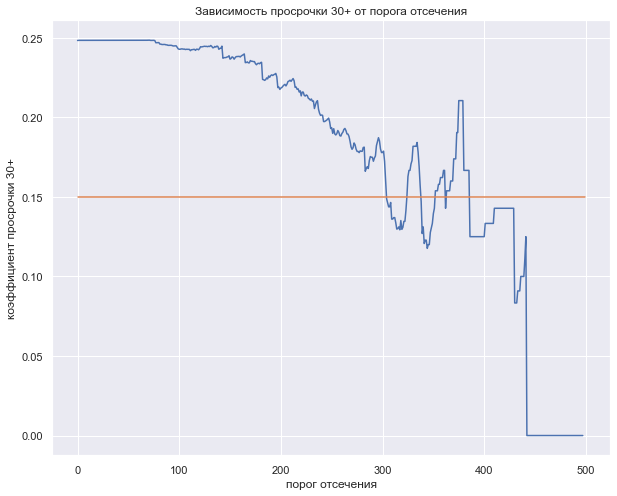

In [14]:
limit = 0.15 
sns.set(rc={'figure.figsize':(10,8)})
sns.lineplot(x = 'score_limit', y = 'coeff_30day_delay', data = delay_30day_by_score_limit)
sns.lineplot(x = (x for x in range(500)), y = limit)
plt.ylabel('коэффициент просрочки 30+')
plt.xlabel('порог отсечения')
plt.title('Зависимость просрочки 30+ от порога отсечения')
plt.show()

Мне кажется, что уровень просрочки 30+ равный 15 % крайне опасное значение, коэффициент просрочки ведет себя нелинейно и при дальнейшем увеличении порога отсечения мы видим резкие колебания коэффициента просрочки. При этом необходимо обратить внимание на изменение объема выданных кредитов, чем и займенмся ниже.

Посмотрим на распределение коэффициента просрочки и на его боксплот

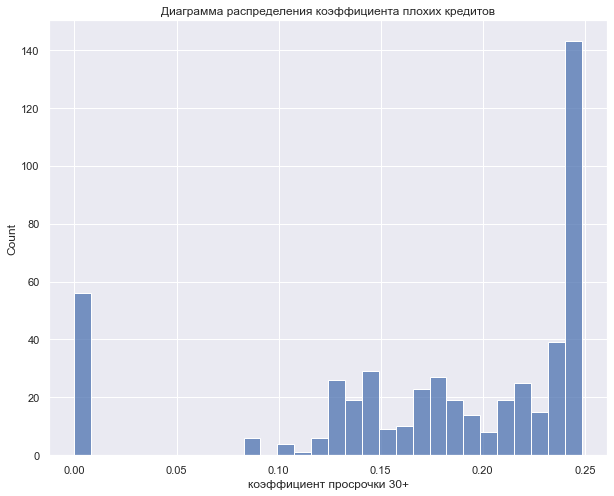

In [15]:
sns.histplot(delay_30day_by_score_limit.coeff_30day_delay, bins = 30, kde = False)
plt.xlabel('коэффициент просрочки 30+')
plt.title('Диаграмма распределения коэффициента плохих кредитов')
plt.show()

#### Посмотрим на зависимость числа выданных, закрытых и просроченных (30+ дней) кредитов от порога отсечения

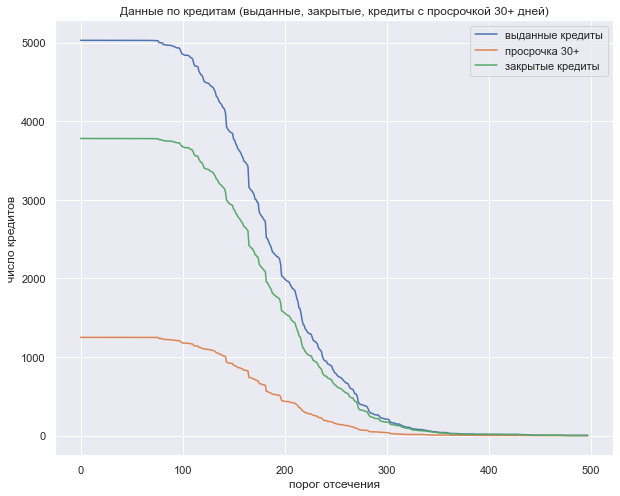

In [16]:
sns.lineplot(x = 'score_limit', y = 'loan_number', data = delay_30day_by_score_limit, label = 'выданные кредиты')
sns.lineplot(x = 'score_limit', y = 'not_churn_30day', data = delay_30day_by_score_limit, label = 'просрочка 30+')
sns.lineplot(x = 'score_limit', y = 'close_loan', data = delay_30day_by_score_limit, label = 'закрытые кредиты')
plt.ylabel('число кредитов')
plt.xlabel('порог отсечения')
plt.legend()
plt.title('Данные по кредитам (выданные, закрытые, кредиты с просрочкой 30+ дней)')
plt.show()

С увеличением порога тсечения по скорингу количество выданных кредитов резко сокращается. С ростом порога отсечения  коэффициент просрочки 30+ становится крайне чувствителен к выбросам, как видно из графика `Зависимость просрочки 30+ от порога отсечения` после порога отсечения > 300 происходят резкие колебания коэффициента, поэтому высока вероятность не добиться желаемого эффекта. 

На текущих данных снизить коэффициент просрочки до 15% можно при пороге отсечения 304-323, но данная граница крайне опасна, так как далее с увеличением порога отсечения, происходит неожиданный рост коэффициента выше 15 %. Кроме того с введением высокого порога отсечения резко упадет количество выданных кредитов (примерно в 30 раз от певоначального уровня, без отсечения по скорингу), соответственно сократится доходность организации.
Я бы проверила саму систему скоринга.

In [17]:
delay_30day_by_score_limit.query('coeff_30day_delay <= 0.15').sort_values('score_limit').head()

,score_limit,coeff_30day_delay,loan_number,not_churn_30day,close_loan
304,304,0.148810,168,25,143
305,305,0.146341,164,24,140
306,306,0.143750,160,23,137
307,307,0.143750,160,23,137
308,308,0.146497,157,23,134
